In [1]:
%matplotlib inline

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import pathlib
import scipy as sp

from scipy.ndimage import label
from skimage.measure import regionprops
from matplotlib import patches

from PIL import Image
import os
from xml.etree.ElementTree import parse

import time

config =  ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
session = InteractiveSession(config=config)

In [2]:
def simple_cam(img_path, class_idx, tl_model):
    ## read image and preprocess it
    img = Image.open(img_path).resize((224, 224))
    img_arr = np.asarray(img)[:, :, :3] / 255.
    img_array = np.expand_dims(img_arr, 0)
    
    ## get prediction result and conv_output values
    features, results = tl_model.predict(img_array)
    features = sp.ndimage.zoom(features[0], (224/14, 224/14, 1), order=2)
    class_weights = tl_model.layers[-1].get_weights()[0]

    ## calculate cam
    cam = np.dot(features, class_weights[:,class_idx])
    ## normalise cam and resize to fit the orginal image size
    ## in this case (224, 224)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    cam_img = np.uint8(255 * cam_img)
    
    cam_img = cv2.resize(cam_img, (224, 224))
    
    return img_arr, cam_img, results

def avg_cam(img_path, tl_model):  
    ## read image and preprocess it
    img = Image.open(img_path).resize((224, 224))
    img_arr = np.asarray(img)[:, :, :3] / 255.
    img_array = np.expand_dims(img_arr, 0)
    
    ## get prediction result and conv_output values
    features, results = tl_model.predict(img_array)
    features = sp.ndimage.zoom(features[0], (224/14, 224/14, 1), order=2)
    class_weights = tl_model.layers[-1].get_weights()[0]
    
    ## calculate cam
    cam = np.zeros((224,224), dtype=float)
    for class_idx in range(7):
        cam += np.dot(features, class_weights[:,class_idx])
    
    cam /= 7
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    cam_img = np.uint8(255*cam_img)
    
    return img_arr, cam_img, results

def back_remove_avg_cam(img_path, class_idx, tl_model):  
    ## read image and preprocess it
    img = Image.open(img_path).resize((224, 224))
    img_arr = np.asarray(img)[:, :, :3] / 255.
    img_array = np.expand_dims(img_arr, 0)
    
    ## get prediction result and conv_output values
    features, results = tl_model.predict(img_array)
    features = sp.ndimage.zoom(features[0], (224/14, 224/14, 1), order=2)#features[0, :, :, :]
    class_weights = tl_model.layers[-1].get_weights()[0]
    
    ## calculate cam
    cam = np.zeros((224,224), dtype=float)
    for class_idx in range(1,8):
        cam += np.dot(features, class_weights[:,class_idx])
        
       
    cam /= 7

    back_cam = np.dot(features, class_weights[:,0])

    cam = cam - back_cam

    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    cam_img = np.uint8(255*cam_img)
    
    return img_arr, cam_img, results

def back_remove_cam(img_path, class_idx,tl_model):  
    ## read image and preprocess it
    img = Image.open(img_path).resize((224, 224))
    img_arr = np.asarray(img)[:, :, :3] / 255.
    img_array = np.expand_dims(img_arr, 0)
    
    ## get prediction result and conv_output values
    features, results = tl_model.predict(img_array)
    features = sp.ndimage.zoom(features[0], (224/14, 224/14, 1), order=2)
    class_weights = tl_model.layers[-1].get_weights()[0]
    
    ## calculate cam
    cam = np.dot(features, class_weights[:,class_idx])
    
    back_cam = np.dot(features, class_weights[:,0])
    cam = cam - back_cam
        
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    cam_img = np.uint8(255*cam_img)
    
    return img_arr, cam_img, results

def get_label(xml):
    p_size = xml.find('size')
    p_box = xml.find('object').find('bndbox')
    size = {'width':int(p_size.find('width').text),'height': int(p_size.find('height').text)}
    box = {'xmin':int(p_box.find('xmin').text), 'ymin' : int(p_box.find('ymin').text),'xmax': int(p_box.find('xmax').text),'ymax': int(p_box.find('ymax').text)}
    xmin, ymin, xmax, ymax = box['xmin'] / size['width'] * 224, box['ymin'] / size['height'] * 224, box['xmax'] / size['width'] * 224,box['ymax'] / size['height'] * 224
    w, h = xmax - xmin, ymax - ymin
    return {'xmin':xmin, 'ymin':ymin, 'xmax':xmax,'ymax':ymax,'w':w, 'h':h}

def generate_bbox(img, cam, threshold):
    labeled, nr_objects = label(cam > threshold)
    props = regionprops(labeled)
    
    init = props[0].bbox_area
    bbox = list(props[0].bbox)
    for b in props:
        if init < b.bbox_area:
            bbox = list(b.bbox)
    return bbox

#boxA[0] : min x, boxA[1] : min y, boxA[2] : max x, boxA[3] : max y
def IoU(boxA, boxB):
    xA = max(boxA[1], boxB['xmin'])
    yA = max(boxA[0], boxB['ymin'])
    xB = min(boxA[3], boxB['xmax'])
    yB = min(boxA[2], boxB['ymax'])

    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB['xmax'] - boxB['xmin'] + 1) * (boxB['ymax'] - boxB['ymin'] + 1)

    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

def avg_blur(bbox, img):
    x = bbox[1]
    y = bbox[0]
    w = bbox[3] - bbox[1]
    h = bbox[2] - bbox[0]
    
    roi = img[y:y+h, x:x+w]
    roi = cv2.blur(roi, (9,9))
    img[y:y+h, x:x+w] = roi
    
    return img

def gaussian_blur(bbox, img):
    x = bbox[1]
    y = bbox[0]
    w = bbox[3] - bbox[1]
    h = bbox[2] - bbox[0]
    
    roi = img[y:y+h, x:x+w]
    roi = cv2.GaussianBlur(roi, (9,9), 0)
    img[y:y+h, x:x+w] = roi
    
    return img

def median_blur(bbox, img):
    x = bbox[1]
    y = bbox[0]
    w = bbox[3] - bbox[1]
    h = bbox[2] - bbox[0]
    
    roi = img[y:y+h, x:x+w]
    roi = cv2.medianBlur(roi.astype(np.uint8), 9)
    img[y:y+h, x:x+w] = roi
    
    return img

def bilateral_filter(bbox, img):
    x = bbox[1]
    y = bbox[0]
    w = bbox[3] - bbox[1]
    h = bbox[2] - bbox[0]
    
    roi = img[y:y+h, x:x+w]
    roi = cv2.bilateralFilter(roi.astype(np.float32), 9, 75, 75)
    img[y:y+h, x:x+w] = roi
    
    return img

In [3]:
model = load_model(f'./VGG16_VOC2012_7_back_1230')

In [4]:
cam_model = tf.keras.Model(model.input, outputs=(model.layers[-3].output, model.layers[-1].output))

In [5]:
IMG_SIZE = 224
batch_size = 64

In [6]:
test_dir = f'VOC2012_7_back_dataset/test'
test_datagen = ImageDataGenerator(rescale=1./255)
test_ds = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE,IMG_SIZE),
    class_mode='categorical'
)

Found 472 images belonging to 8 classes.


In [7]:
for class_name, class_idx in test_ds.class_indices.items():
    print(class_name, class_idx)

0background 0
aeroplane 1
bird 2
car 3
cat 4
dog 5
person 6
train 7


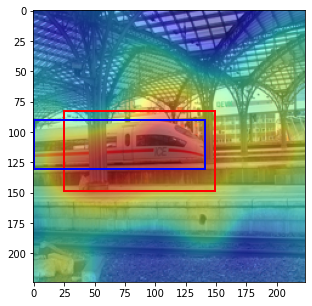

0.5167420787195293


In [8]:
index = 1
sample = os.listdir(f'{test_dir}/train')
img_arr, cam, results = back_remove_avg_cam(f'{test_dir}/train/{sample[index]}', 7, cam_model)

tree = parse(f'VOC2012/Annotations/{sample[index].replace("jpg","xml")}')
box = get_label(tree)
bbox = generate_bbox(img_arr, cam, 255*0.8)

plt.figure(figsize=(5,5))
plt.imshow(cam, cmap='jet', alpha=0.9)
plt.imshow(img_arr, alpha=0.5)
ax = plt.gca()

xs = bbox[1]
ys = bbox[0]
w = bbox[3] - bbox[1]
h = bbox[2] - bbox[0]

rect = patches.Rectangle((xs, ys), w, h, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)

rect = patches.Rectangle((box['xmin'], box['ymin']), box['w'], box['h'], linewidth=2, edgecolor='b', facecolor='none')
ax.add_patch(rect)

plt.show()

print(IoU(bbox, box))